In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV

from pathlib import Path

# Load data
project_root = Path.cwd().resolve()
csv_path = project_root.parent / "data" / "creditcard.csv"
if not csv_path.exists():
    csv_path = project_root / "data" / "creditcard.csv"
df = pd.read_csv(csv_path)

X = df.drop("Class", axis=1)
y = df["Class"]

# train-val-test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
val_preds   = lr.predict(X_val)
test_preds  = lr.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, train_preds))
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))



Train Accuracy: 0.9767501740957263
Validation Accuracy: 0.9751939889751062
Test Accuracy: 0.9758084336926371


In [2]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
val_preds   = lr.predict(X_val)
test_preds  = lr.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, train_preds))
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))

Train Accuracy: 0.9767501740957263
Validation Accuracy: 0.9751939889751062
Test Accuracy: 0.9758084336926371


In [3]:
# Calibrate the model using isotonic regression
calibrated_lr = CalibratedClassifierCV(
    lr,
    method="isotonic",
    cv="prefit"
)

calibrated_lr.fit(X_val, y_val)
cal_probs = calibrated_lr.predict_proba(X_test)
raw_probs = lr.predict_proba(X_test)

def entropy(p):
    return -np.sum(p*np.log(p+1e-9), axis=1)

raw_conf = np.mean(np.max(raw_probs, axis=1))
cal_conf = np.mean(np.max(cal_probs, axis=1))

raw_ent = np.mean(entropy(raw_probs))
cal_ent = np.mean(entropy(cal_probs))

print("Raw Mean Confidence:", raw_conf)
print("Calibrated Mean Confidence:", cal_conf)

print("Raw Mean Entropy:", raw_ent)
print("Calibrated Mean Entropy:", cal_ent)

Raw Mean Confidence: 0.9466868234689161
Calibrated Mean Confidence: 0.9991943343855648
Raw Mean Entropy: 0.1558466787521086
Calibrated Mean Entropy: 0.0035259783363054626


c:\Users\mukun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [5]:
# Calibrate the model using sigmoid regression
calibrated_lr = CalibratedClassifierCV(
    lr,
    method="sigmoid",
    cv="prefit"
)

calibrated_lr.fit(X_val, y_val)
cal_probs = calibrated_lr.predict_proba(X_test)
raw_probs = lr.predict_proba(X_test)

def entropy(p):
    return -np.sum(p*np.log(p+1e-9), axis=1)

raw_conf = np.mean(np.max(raw_probs, axis=1))
cal_conf = np.mean(np.max(cal_probs, axis=1))

raw_ent = np.mean(entropy(raw_probs))
cal_ent = np.mean(entropy(cal_probs))

print("Raw Mean Confidence:", raw_conf)
print("Calibrated Mean Confidence:", cal_conf)

print("Raw Mean Entropy:", raw_ent)
print("Calibrated Mean Entropy:", cal_ent)

Raw Mean Confidence: 0.9466868234689161
Calibrated Mean Confidence: 0.9991509334001027
Raw Mean Entropy: 0.1558466787521086
Calibrated Mean Entropy: 0.005721304596405551


c:\Users\mukun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [6]:
# Expected Calibration Error (ECE)
def expected_calibration_error(probs, y, n_bins=10):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)

    bins = np.linspace(0,1,n_bins+1)
    ece = 0.0

    for i in range(n_bins):
        idx = (confidences > bins[i]) & (confidences <= bins[i+1])
        if np.sum(idx) == 0:
            continue

        acc = np.mean(predictions[idx] == y.iloc[idx])
        conf = np.mean(confidences[idx])
        ece += np.abs(acc - conf) * np.sum(idx) / len(y)

    return ece

raw_ece = expected_calibration_error(raw_probs, y_test.reset_index(drop=True))
cal_ece = expected_calibration_error(cal_probs, y_test.reset_index(drop=True))

print("Raw ECE:", raw_ece)
print("Calibrated ECE:", cal_ece)

Raw ECE: 0.029121610223721145
Calibrated ECE: 0.00034575402177055355


In [7]:
#drift
def noise_drift(X, intensity):
    return X + np.random.normal(0, intensity, X.shape)

drift_levels = [0.0, 0.2, 0.5, 1.0]

results = []

for d in drift_levels:
    Xd = noise_drift(X_test, d)

    raw_probs_d = lr.predict_proba(Xd)
    cal_probs_d = calibrated_lr.predict_proba(Xd)

    raw_conf = np.mean(np.max(raw_probs_d, axis=1))
    cal_conf = np.mean(np.max(cal_probs_d, axis=1))

    raw_ent = np.mean(entropy(raw_probs_d))
    cal_ent = np.mean(entropy(cal_probs_d))

    raw_acc = accuracy_score(y_test, np.argmax(raw_probs_d, axis=1))
    cal_acc = accuracy_score(y_test, np.argmax(cal_probs_d, axis=1))

    results.append([d, raw_acc, cal_acc, raw_conf, cal_conf, raw_ent, cal_ent])
print("\nDrift Results (Intensity, Raw Acc, Cal Acc, Raw Conf, Cal Conf, Raw Ent, Cal Ent):")
for res in results:
    print(res)
    

drift = [r[0] for r in results]
raw_acc = [r[1] for r in results]
cal_acc = [r[2] for r in results]
raw_conf = [r[3] for r in results]
cal_conf = [r[4] for r in results]



Drift Results (Intensity, Raw Acc, Cal Acc, Raw Conf, Cal Conf, Raw Ent, Cal Ent):
[0.0, 0.9758084336926371, 0.9990519995786665, np.float64(0.9466868234689161), np.float64(0.9991509334001027), np.float64(0.15584667875210864), np.float64(0.005721304596405551)]
[0.2, 0.9614655384291282, 0.9990519995786665, np.float64(0.9372807255396194), np.float64(0.999129213045438), np.float64(0.1695808275214168), np.float64(0.0058555023814127975)]
[0.5, 0.8814297250798778, 0.9991222218320986, np.float64(0.9188152405756771), np.float64(0.9989823469628797), np.float64(0.19317741252331677), np.float64(0.006671263270253382)]
[1.0, 0.75436255749447, 0.9990168884519505, np.float64(0.9288999274410515), np.float64(0.9982960385228116), np.float64(0.16624699128420345), np.float64(0.010248236314347044)]


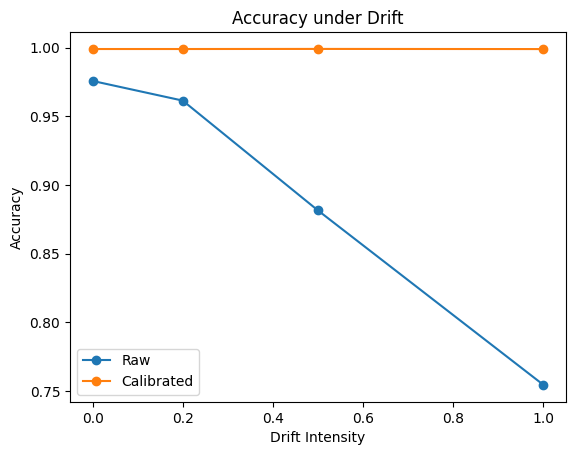

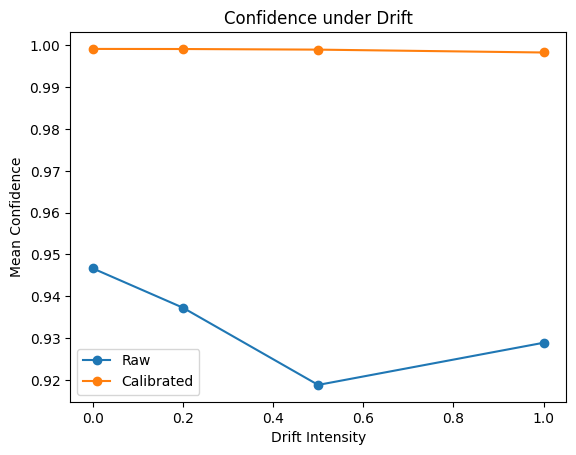

In [8]:
plt.figure()
plt.plot(drift, raw_acc, marker='o')
plt.plot(drift, cal_acc, marker='o')
plt.xlabel("Drift Intensity")
plt.ylabel("Accuracy")
plt.title("Accuracy under Drift")
plt.legend(["Raw", "Calibrated"])
plt.show()

plt.figure()
plt.plot(drift, raw_conf, marker='o')
plt.plot(drift, cal_conf, marker='o')
plt.xlabel("Drift Intensity")
plt.ylabel("Mean Confidence")
plt.title("Confidence under Drift")
plt.legend(["Raw", "Calibrated"])
plt.show()
